# Statewide Visualization Code

In [ ]:
#!/usr/bin/env python3
"""
Unified Statewide Visualization Notebook
=========================================

Generates standardized visualizations for California statewide LiDAR-derived products.

Dependencies:
    - numpy
    - scipy
    - matplotlib
    - tifffile (lightweight GeoTIFF reader, install via: pip install tifffile)
    - imagecodecs (for compressed GeoTIFFs)
"""

# =============================================================================
# IMPORTS
# =============================================================================

import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import os
from typing import Tuple, Optional, Dict, Any
import tifffile
import imagecodecs

# Configure matplotlib for notebook display
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'

# =============================================================================
# CONFIGURATION
# =============================================================================

# Set your base directory here (where all the 30 meter statewide resolution products live)
BASE_DIR = "/path/to/statewide_data_products"  # <-- UPDATE THIS PATH

# Product configuration dictionary with product-specific colormaps
PRODUCT_CONFIG: Dict[str, Dict[str, Any]] = {
    # Topographic Products
    'dtm': {
        'description': 'Digital Terrain Model (Bare Earth)',
        'units': 'm',
        'filename_pattern': 'california_statewide_30m_epsg3310_dtm.tif',
        'vmin_percentile': 1,
        'vmax_percentile': 99,
        'cmap': 'terrain',
    },
    'dsm': {
        'description': 'Digital Surface Model',
        'units': 'm',
        'filename_pattern': 'california_statewide_30m_epsg3310_dsm.tif',
        'vmin_percentile': 1,
        'vmax_percentile': 99,
        'cmap': 'terrain',
    },
    'chm': {
        'description': 'Canopy Height Model',
        'units': 'm',
        'filename_pattern': 'california_statewide_30m_epsg3310_chm.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 99,
        'cmap': 'Greens',
    },
    'aspect': {
        'description': 'Terrain Aspect',
        'units': '°',
        'filename_pattern': 'california_statewide_30m_epsg3310_aspect.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 100,
        'cmap': 'cividis',
    },
    'slope': {
        'description': 'Terrain Slope',
        'units': '°',
        'filename_pattern': 'california_statewide_30m_epsg3310_slope.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 99,
        'cmap': 'cividis',
    },
    
    # Canopy Cover - All Returns
    'cc_all_ge2': {
        'description': 'Canopy Cover (All Returns ≥2m)',
        'units': '%',
        'filename_pattern': 'california_statewide_30m_cc_all_ge2_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 100,
        'cmap': 'plasma',
    },
    'cc_all_2_4': {
        'description': 'Canopy Cover (All Returns 2-4m)',
        'units': '%',
        'filename_pattern': 'california_statewide_30m_cc_all_2_4_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 100,
        'cmap': 'plasma',
    },
    'cc_all_4_8': {
        'description': 'Canopy Cover (All Returns 4-8m)',
        'units': '%',
        'filename_pattern': 'california_statewide_30m_cc_all_4_8_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 100,
        'cmap': 'plasma',
    },
    
    # Canopy Cover - First Returns
    'cc_first_ge2': {
        'description': 'Canopy Cover (First Returns ≥2m)',
        'units': '%',
        'filename_pattern': 'california_statewide_30m_cc_first_ge2_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 100,
        'cmap': 'plasma',
    },
    'cc_first_2_4': {
        'description': 'Canopy Cover (First Returns 2-4m)',
        'units': '%',
        'filename_pattern': 'california_statewide_30m_cc_first_2_4_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 100,
        'cmap': 'plasma',
    },
    'cc_first_4_8': {
        'description': 'Canopy Cover (First Returns 4-8m)',
        'units': '%',
        'filename_pattern': 'california_statewide_30m_cc_first_4_8_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 100,
        'cmap': 'plasma',
    },
    
    # Height Percentiles
    'p10': {
        'description': '10th Percentile Height (First Returns)',
        'units': 'm',
        'filename_pattern': 'california_statewide_30m_p10_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'p25': {
        'description': '25th Percentile Height (First Returns)',
        'units': 'm',
        'filename_pattern': 'california_statewide_30m_p25_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'p50': {
        'description': '50th Percentile Height (First Returns)',
        'units': 'm',
        'filename_pattern': 'california_statewide_30m_p50_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'p75': {
        'description': '75th Percentile Height (First Returns)',
        'units': 'm',
        'filename_pattern': 'california_statewide_30m_p75_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'p90': {
        'description': '90th Percentile Height (First Returns)',
        'units': 'm',
        'filename_pattern': 'california_statewide_30m_p90_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'p95': {
        'description': '95th Percentile Height (First Returns)',
        'units': 'm',
        'filename_pattern': 'california_statewide_30m_p95_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'p99': {
        'description': '99th Percentile Height (First Returns)',
        'units': 'm',
        'filename_pattern': 'california_statewide_30m_p99_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    
    # Structure Metrics
    'sd': {
        'description': 'Standard Deviation (First Returns)',
        'units': 'm',
        'filename_pattern': 'california_statewide_30m_sd_first_epsg3310.tif',
        'vmin_percentile': 0,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'skewness': {
        'description': 'Skewness (First Returns)',
        'units': '',
        'filename_pattern': 'california_statewide_30m_skewness_first_epsg3310.tif',
        'vmin_percentile': 2,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
    'kurtosis': {
        'description': 'Kurtosis (First Returns)',
        'units': '',
        'filename_pattern': 'california_statewide_30m_kurtosis_first_epsg3310.tif',
        'vmin_percentile': 2,
        'vmax_percentile': 98,
        'cmap': 'plasma',
    },
}


# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def list_available_products() -> None:
    """Print all available map types with their colormaps."""
    print("\n" + "=" * 70)
    print("AVAILABLE MAP TYPES")
    print("=" * 70)
    
    categories = {
        'Topographic': ['dtm', 'dsm', 'chm', 'aspect', 'slope'],
        'Canopy Cover (All Returns)': ['cc_all_ge2', 'cc_all_2_4', 'cc_all_4_8'],
        'Canopy Cover (First Returns)': ['cc_first_ge2', 'cc_first_2_4', 'cc_first_4_8'],
        'Height Percentiles': ['p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99'],
        'Statistics': ['sd', 'skewness', 'kurtosis'],
    }
    
    for category, products in categories.items():
        print(f"\n{category}:")
        print("-" * 50)
        for prod in products:
            if prod in PRODUCT_CONFIG:
                config = PRODUCT_CONFIG[prod]
                print(f"  {prod:15s} - {config['description']:40s}")
    
    print("\n" + "=" * 70)


def read_geotiff(filepath: str) -> Tuple[np.ndarray, Optional[float]]:
    """
    Read a GeoTIFF file using tifffile.
    
    Parameters
    ----------
    filepath : str
        Path to the GeoTIFF file
        
    Returns
    -------
    data : np.ndarray
        The raster data
    nodata : float or None
        NoData value if found in tags, else None
    """
    with tifffile.TiffFile(filepath) as tif:
        data = tif.asarray()
        
        # Try to extract NoData value from GeoTIFF tags
        nodata = None
        for page in tif.pages:
            # Check for GDAL NoData tag (42113)
            if 42113 in page.tags:
                try:
                    nodata = float(page.tags[42113].value)
                except (ValueError, TypeError):
                    pass
                break
    
    return data, nodata


def downsample_array(data: np.ndarray, factor: int) -> np.ndarray:
    """
    Downsample a 2D array by a given factor using block averaging.
    
    Parameters
    ----------
    data : np.ndarray
        Input 2D array
    factor : int
        Downsampling factor
        
    Returns
    -------
    np.ndarray
        Downsampled array
    """
    if factor <= 1:
        return data
    
    # Trim array to be divisible by factor
    new_height = (data.shape[0] // factor) * factor
    new_width = (data.shape[1] // factor) * factor
    trimmed = data[:new_height, :new_width]
    
    # Reshape and compute mean (handles NaN via nanmean)
    reshaped = trimmed.reshape(
        trimmed.shape[0] // factor, factor,
        trimmed.shape[1] // factor, factor
    )
    
    # Use nanmean to handle masked/NaN values
    with np.errstate(all='ignore'):
        downsampled = np.nanmean(reshaped, axis=(1, 3))
    
    return downsampled


def mask_nodata(data: np.ndarray, nodata: Optional[float] = None) -> np.ndarray:
    """
    Mask NoData and invalid values, returning array with NaN for invalid pixels.
    
    Parameters
    ----------
    data : np.ndarray
        Input data array
    nodata : float, optional
        NoData value from raster metadata
        
    Returns
    -------
    np.ndarray
        Array with invalid values set to NaN
    """
    # Convert to float to allow NaN
    result = data.astype(np.float64)
    
    # Create mask for invalid values
    mask = np.zeros(data.shape, dtype=bool)
    
    # Mask specified NoData value
    if nodata is not None:
        mask |= np.isclose(result, nodata, rtol=1e-5, equal_nan=True)
    
    # Mask common NoData values
    mask |= np.isclose(result, -9999, rtol=1e-5)
    mask |= (result < -9000)
    mask |= (result > 4000)
    mask |= np.isnan(result)
    mask |= np.isinf(result)
    
    # Set masked values to NaN
    result[mask] = np.nan
    
    return result


def compute_statistics(data: np.ndarray) -> Dict[str, float]:
    """
    Compute statistics on valid (non-NaN) data.
    
    Parameters
    ----------
    data : np.ndarray
        Input array (may contain NaN)
        
    Returns
    -------
    dict
        Dictionary of statistics
    """
    valid = data[~np.isnan(data)]
    
    if len(valid) == 0:
        return {'valid_count': 0}
    
    return {
        'valid_count': len(valid),
        'valid_percent': 100 * len(valid) / data.size,
        'min': float(np.min(valid)),
        'max': float(np.max(valid)),
        'mean': float(np.mean(valid)),
        'median': float(np.median(valid)),
        'std': float(np.std(valid)),
    }


# =============================================================================
# MAIN VISUALIZATION FUNCTION
# =============================================================================

def visualize_statewide(
    map_type: str,
    base_dir: str = BASE_DIR,
    downsample_factor: int = 10,
    figsize: Tuple[int, int] = (14, 10),
    save_path: Optional[str] = None,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    cmap: Optional[str] = None,
    dpi: int = 300
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Create a statewide visualization for a given map type.
    
    Parameters
    ----------
    map_type : str
        Product type (e.g., 'dtm', 'chm', 'cc_all_ge2', 'p99')
    base_dir : str
        Base directory containing the statewide GeoTIFF files
    downsample_factor : int
        Factor to downsample by for memory efficiency (default: 100)
    figsize : tuple
        Figure size (width, height) in inches
    save_path : str, optional
        Path to save figure (if None, only displays)
    vmin : float, optional
        Override minimum value for color scale
    vmax : float, optional
        Override maximum value for color scale
    cmap : str, optional
        Override colormap (if None, uses product-specific default)
    dpi : int
        DPI for saved figure (default: 300)
        
    Returns
    -------
    fig, ax : matplotlib figure and axis objects
    
    Examples
    --------
    >>> fig, ax = visualize_statewide('dtm')
    >>> fig, ax = visualize_statewide('chm', downsample_factor=50)
    >>> fig, ax = visualize_statewide('p99', save_path='p99_map.png')
    >>> fig, ax = visualize_statewide('dtm', cmap='viridis')  # Override colormap
    """
    
    # Validate map type
    if map_type not in PRODUCT_CONFIG:
        print(f"ERROR: Unknown map type '{map_type}'")
        print(f"Available types: {list(PRODUCT_CONFIG.keys())}")
        print("\nRun list_available_products() to see all options.")
        return None, None
    
    config = PRODUCT_CONFIG[map_type]
    filepath = os.path.join(base_dir, config['filename_pattern'])
    
    # Check file exists
    if not os.path.exists(filepath):
        print(f"ERROR: File not found: {filepath}")
        print(f"\nCheck that BASE_DIR is set correctly: {base_dir}")
        return None, None
    
    print(f"Product: {config['description']}")
    print(f"Reading: {filepath}")
    
    # Read the GeoTIFF
    data, nodata = read_geotiff(filepath)
    
    # Mask NoData values
    data = mask_nodata(data, nodata)
    
    # Downsample
    print(f"Downsampling by factor of {downsample_factor}...")
    data = downsample_array(data, downsample_factor)
    
    # Determine color scale limits
    valid_data = data[~np.isnan(data)]
    
    vmin_val = vmin if vmin is not None else np.percentile(valid_data, config['vmin_percentile'])
    vmax_val = vmax if vmax is not None else np.percentile(valid_data, config['vmax_percentile'])
    
    # Use provided colormap or product-specific default
    colormap = cmap if cmap is not None else config['cmap']
        
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot with product-specific colormap
    im = ax.imshow(
        data,
        cmap=colormap,
        interpolation='nearest',
        vmin=vmin_val,
        vmax=vmax_val
    )
    
    # Add colorbar
    units_label = f" ({config['units']})" if config['units'] else ""
    cbar = plt.colorbar(im, ax=ax, label=f"{config['description']}{units_label}", shrink=0.8)
    
    # Set title and labels
    ax.set_title(
        f"California Statewide {config['description']} (30m)",
        fontsize=16,
        fontweight='bold'
    )
    ax.set_xlabel('X (pixels)', fontsize=12)
    ax.set_ylabel('Y (pixels)', fontsize=12)
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        print(f"\nSaving figure to {save_path}...")
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print("Saved!")
    
    plt.show()
    
    return fig, ax


AVAILABLE MAP TYPES

Topographic:
--------------------------------------------------
  dtm             - Digital Terrain Model (Bare Earth)      
  dsm             - Digital Surface Model                   
  chm             - Canopy Height Model                     
  aspect          - Terrain Aspect                          
  slope           - Terrain Slope                           

Canopy Cover (All Returns):
--------------------------------------------------
  cc_all_ge2      - Canopy Cover (All Returns ≥2m)          
  cc_all_2_4      - Canopy Cover (All Returns 2-4m)         
  cc_all_4_8      - Canopy Cover (All Returns 4-8m)         

Canopy Cover (First Returns):
--------------------------------------------------
  cc_first_ge2    - Canopy Cover (First Returns ≥2m)        
  cc_first_2_4    - Canopy Cover (First Returns 2-4m)       
  cc_first_4_8    - Canopy Cover (First Returns 4-8m)       

Height Percentiles:
--------------------------------------------------
  p10    

/var/tmp/pbs.23643027.pbspl1.nas.nasa.gov/ipykernel_2383/1777627085.py:316: RuntimeWarning: Mean of empty slice
  downsampled = np.nanmean(reshaped, axis=(1, 3))


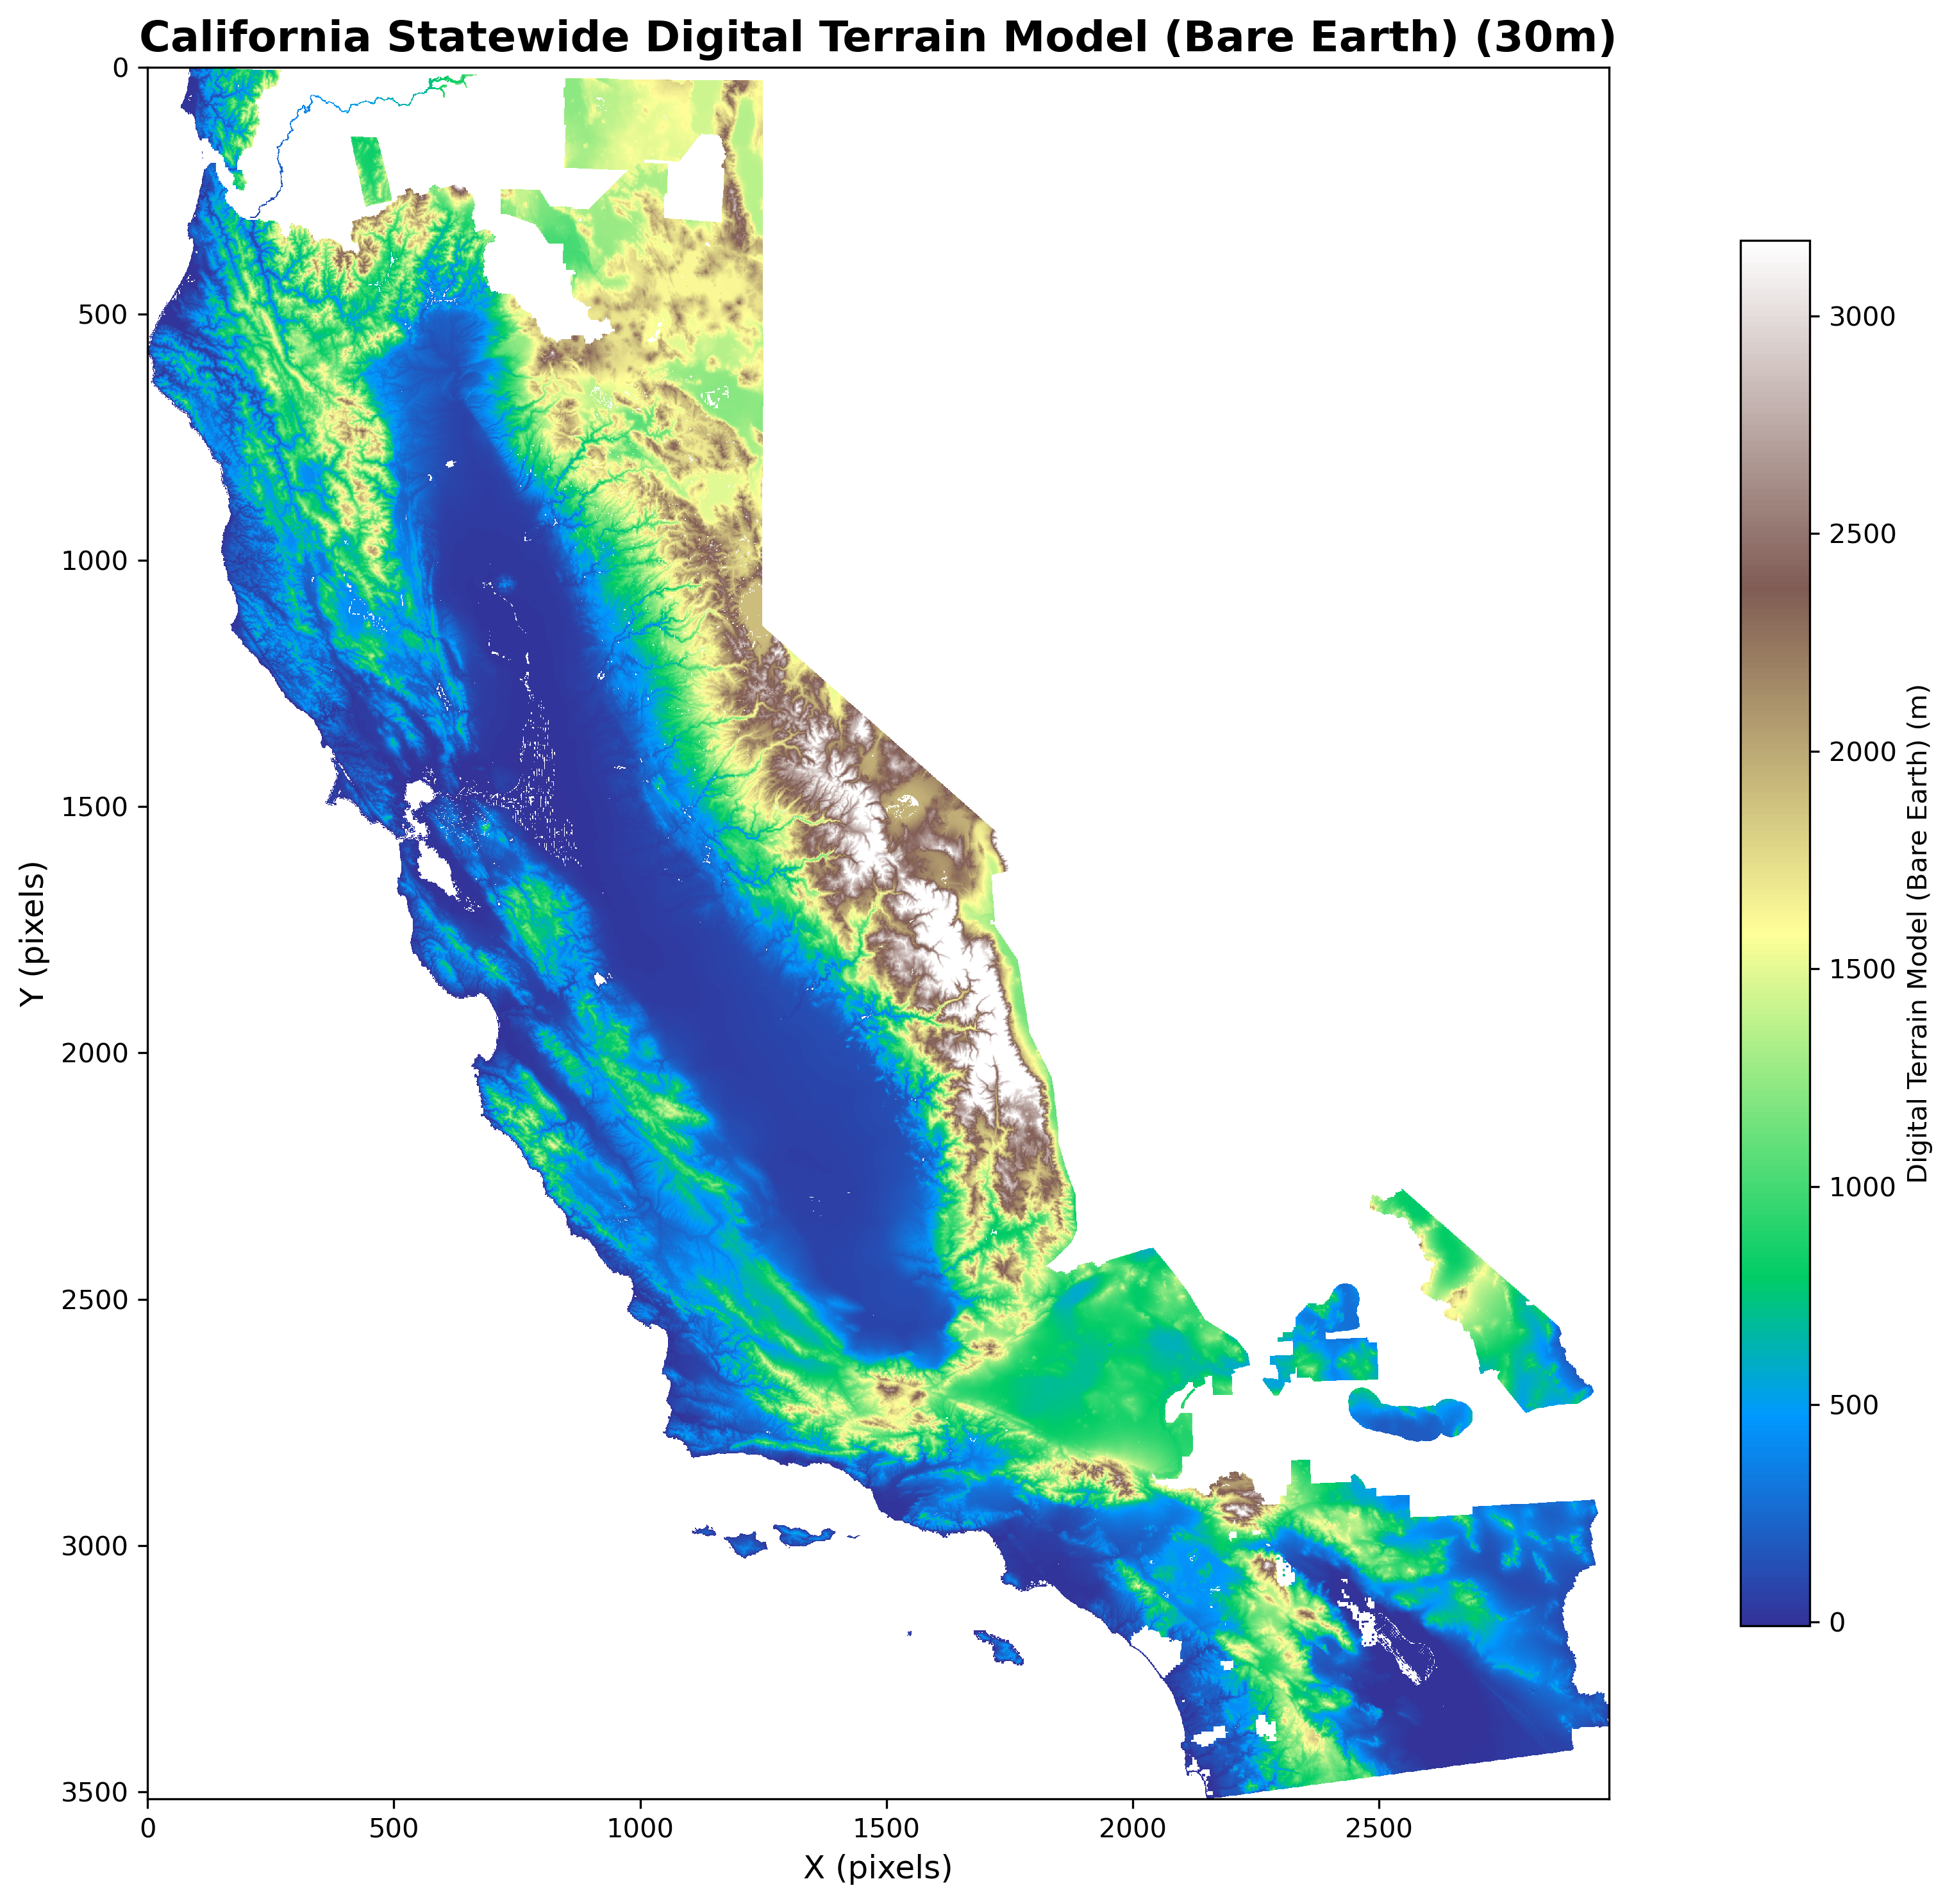

In [13]:
# Run this cell to see all available map types and their colormaps:
list_available_products()

# Example: Visualize DTM 
fig, ax = visualize_statewide(map_type='dtm',downsample_factor = 10)


In [ ]:
# Example: Visualize 90th Percentile Height
fig, ax = visualize_statewide(map_type='p90',downsample_factor = 10)


Product: 90th Percentile Height (First Returns)
Reading: /nobackupp27/kkabasar/public_old/3DEP_mosaics/statewide_30m_canopy_percentiles/california_statewide_30m_p90_first_epsg3310.tif
Downsampling by factor of 10...


Product: Canopy Height Model
Reading: /nobackupp27/kkabasar/public_old/3DEP_mosaics/statewide_30m_canopy_percentiles/california_statewide_30m_epsg3310_chm.tif
Downsampling by factor of 10...


/var/tmp/pbs.23643027.pbspl1.nas.nasa.gov/ipykernel_2383/1777627085.py:316: RuntimeWarning: Mean of empty slice
  downsampled = np.nanmean(reshaped, axis=(1, 3))


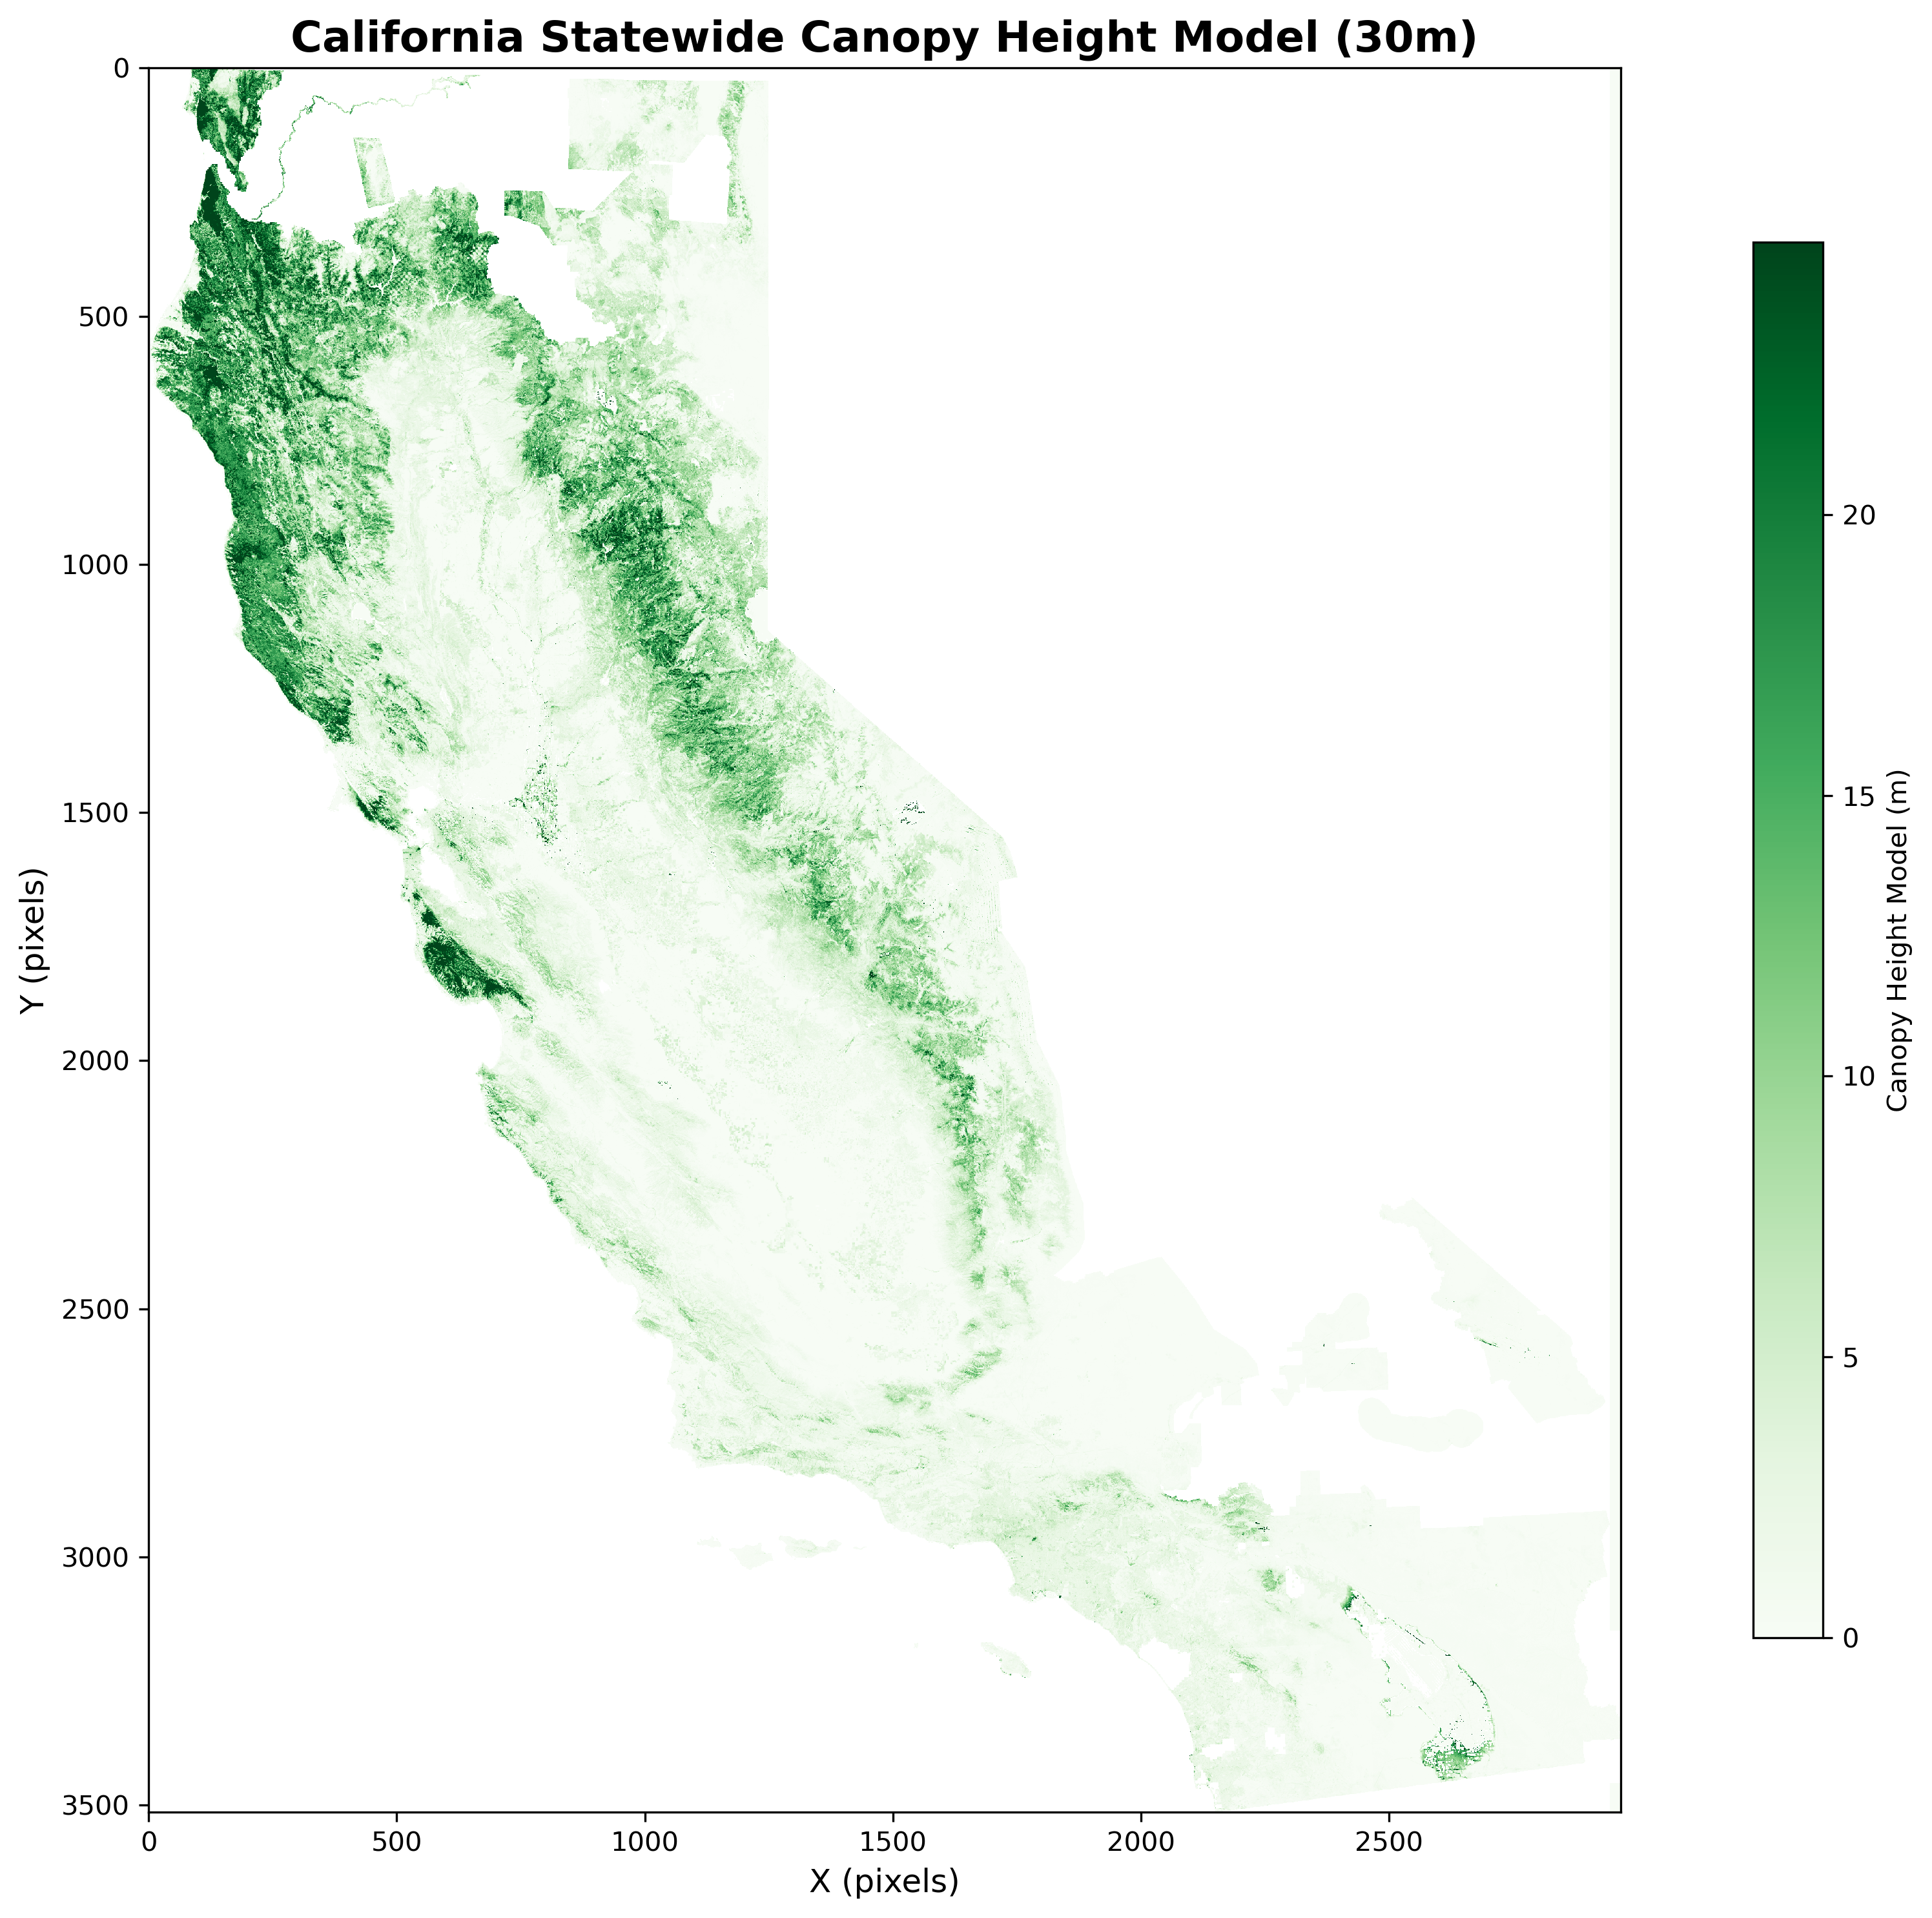

In [16]:
# Example: Visualize Canopy Height Model
fig, ax = visualize_statewide(map_type='chm',downsample_factor = 10)
